In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('../notebooks/style.mpl')

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [287]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [288]:
rho  = 1.0
qMc = 12.0

In [289]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = rho * phi_cat * gamma_cat_inv * tau
    nu_resp = rho * phi_resp * gamma_resp_inv * tau
    nu_ana = rho * phi_ana * gamma_ana_inv * tau * (ATP)/(KM + ATP)
    
    mu = qMc * nu_ana
    Jh = rho * phi_h * gamma_hom_inv * tau
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    dNADH = 2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * (NADH + NAD)
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana  - Jh - maint - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

### Parameters

In [309]:
# gamma inverses are in /hr units.
gamma_cat_inv = 5e-5*3600
gamma_resp_inv = 5e-5*3600
gamma_ana_inv = 5e-5*3600
gamma_hom_inv = 5e-5*3600

phi_cat = 0.3
phi_ana = 0.4
phi_resp = 0.05
phi_h = 0.01
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.032

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism
S6 = 1.0    # reduction coefficient of biomass

### Initial conditions

In [310]:
# concentrations in KM units
Corg0 = 1e2
NADH0 = 1e-3
O20 = 1e1
ATP0 = 1e-3

# KM is in uM
KM = 1e-4
r1 = 100.
r2 = 0.1

### Dynamics

In [311]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )

In [312]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = rho * phi_cat * gamma_cat_inv * tau
    nu_resp = rho * phi_resp * gamma_resp_inv * tau 
    nu_ana = rho * phi_ana * gamma_ana_inv * tau * (ATP)/(KM + ATP)
    
    mu = qMc * nu_ana
    Jh = rho * phi_h * gamma_hom_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana, mu])

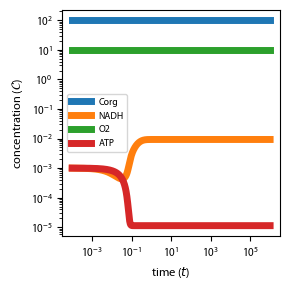

In [313]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [314]:
def is_steady(y_sol, eps):
    # Check if solution has reached steady state
    # by checking if the values at index 1 and -1 are constant and above eps
    return y_sol[1,-1] > eps and y_sol[-1,-1] > eps and np.abs(np.diff(y_sol[1,:]))[-1] < eps and np.abs(np.diff(y_sol[-1,:]))[-1] < eps

In [315]:
is_steady(y_sol, 1e-4)

False

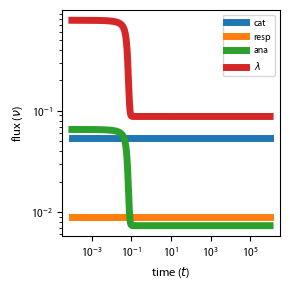

In [316]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(4):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana', r'$\lambda$' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Variable $\phi_h$

In [332]:
LB_CONC = 1e-20  # threshold concentration
UB_CONC = 1e20   # threshold concentration

opt_atps = []
opt_nadhs = []
opt_mus = []
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
opt_phi_os = []
s6s = []

# concentrations in KM units
NADH0 = 1e-3
ATP0 = 1e-3

eps = 1e-10 # define your own value for eps here

# Set fixed values for phi_o and maintenance
phi_o = 0.3
maint = 0.032

for S6 in [1.0]:#np.linspace(-1, 2, 3):
    anas_to_sample = np.linspace(0.01, 0.9, 10)
    resps_to_sample = np.linspace(0.01, 0.7, 10)
    cats_to_sample = np.linspace(0.01, 0.4, 10)

    allatps, allnadhs, allmus, allphis = [], [], [], []
    for phi_ana in anas_to_sample:
        for phi_resp in resps_to_sample:
            for phi_cat in cats_to_sample:
                phi_h = 0.02
                phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)
                # make sure that phi_h is positive.
                if phi_o < 0.4:
                    continue

                y0 = np.array([Corg0, NADH0, O20, ATP0])
                NUM_METS = len(y0)

                # Evaluation time
                TFINAL = 1e6
                t = np.logspace(-4, 6, 1000)

                y_sol = solve_ivp(het_model, [1e-4, TFINAL], y0, t_eval=t, method='Radau').y

                if is_steady(y_sol, eps):
                    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

                    allatps.append(y_sol[-1, -1])
                    allnadhs.append(y_sol[1, -1])
                    allmus.append(nus[-1, -1])
                    allphis.append([phi_cat, phi_resp, phi_ana, phi_h, phi_o])

    if len(allmus) > 0:
        # Filter out solutions with ATP or NADH below LB_CONC
        valid_indices = [i for i, (atp, nadh) in enumerate(zip(allatps, allnadhs)) if atp >= LB_CONC and nadh >= LB_CONC and atp <= UB_CONC and nadh <= UB_CONC]

        allatps = [allatps[i] for i in valid_indices]
        allnadhs = [allnadhs[i] for i in valid_indices]
        allmus = [allmus[i] for i in valid_indices]
        allphis = [allphis[i] for i in valid_indices]

        # Check if any valid solutions remain
        if len(allmus) > 0:
            mus = np.array(allmus)
            max_index = np.argmax(mus)  # finding growth-optimal index
            phi_cat, phi_resp, phi_ana, phi_h, phi_o = allphis[max_index]  # optimal phis

            # storing optimized ATP*, NADH* and optimal phi_resp.
            opt_atps.append(allatps[max_index])
            opt_nadhs.append(allnadhs[max_index])
            opt_phi_cats.append(phi_cat)
            opt_phi_resps.append(phi_resp)
            opt_phi_anas.append(phi_ana)
            opt_phi_hs.append(phi_h)
            opt_phi_os.append(phi_o)
            opt_mus.append(allmus[max_index])
            s6s.append(S6)

df = pd.DataFrame({'atps': opt_atps,
                   'nadhs': opt_nadhs,
                   's6s': s6s,
                   'mus': opt_mus,
                   'opt_phi_cat': opt_phi_cats,
                   'opt_phi_resp': opt_phi_resps,
                   'opt_phi_ana': opt_phi_anas,
                   'opt_phi_h': opt_phi_hs,
                   'opt_phi_o': opt_phi_os
                   })


In [333]:
df

,atps,nadhs,s6s,mus,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,opt_phi_o
0,0.000062,0.002984,1.0,0.171575,0.27,0.086667,0.207778,0.02,0.415556


## Testing dynamics for some sample combinations

In [334]:
# Set the index manually
ind = 0  # You can change this value to the index you want

# Retrieve the values from the DataFrame based on the index
phi_cat = df.loc[ind, 'opt_phi_cat']
phi_resp = df.loc[ind, 'opt_phi_resp']
phi_ana = df.loc[ind, 'opt_phi_ana']
phi_h = df.loc[ind, 'opt_phi_h']
phi_o = df.loc[ind, 'opt_phi_o']

# Print the values to check
print("phi_cat:", phi_cat)
print("phi_resp:", phi_resp)
print("phi_ana:", phi_ana)
print("phi_h:", phi_h)
print("phi_o:", phi_o)

phi_cat: 0.27
phi_resp: 0.08666666666666666
phi_ana: 0.20777777777777778
phi_h: 0.02
phi_o: 0.41555555555555557


In [335]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )

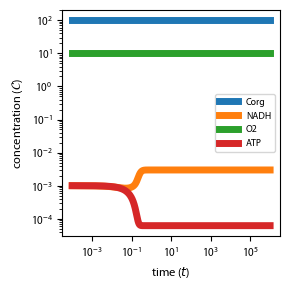

In [336]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

fig, ax = plt.subplots( 1, 1, figsize=(3,3) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [337]:
# Assuming y_sol is already defined and has the required shape
values_to_print = y_sol[[1, -1], -1]

for value in values_to_print:
    print('{:.6e}'.format(value))


2.983540e-03
6.189031e-05
